##### Disclaimers 
This material is derived from **[scikit-learn-mooc](https://github.com/INRIA/scikit-learn-mooc)** under the fair-usage clause of `Creative Commons`.

*References to all the sources apart from the scikit-learn-mooc are linked*

### SIXTH SESSION

#### Comparing model performance with a simple baseline

In this section, we present how to compare the generalization performance of a model to a minimal baseline. In regression, we can use the `DummyRegressor` class to predict the mean target value observed on the training set without using the input features.

Across all evaluations, we will use a `ShuffleSplit` cross-validation splitter with 20% of the data held on the validation side of the split.

We start by running the cross-validation for a simple decision tree regressor. Besides, we will store the testing error in a pandas series to make it easier to plot the results.

Then, we evaluate our baseline with a dummy regressor.

This dummy regressor will always predict the mean target computed on the training target. Therefore, the dummy regressor does not use any information from the input features stored in the dataframe named `data`

We then plot the cross-validation testing errors for the mean target baseline and the actual decision tree regressor.

We see that our decision tree's generalization performance is far from perfect: the price predictions are off by more than 45,000 US dollars on average. 

However, it is much better than the mean price baseline. So this confirms that it is possible to predict the housing price much better by using a model that considers the values of the input features (housing location, size, neighborhood income). Such a model makes more informed predictions and divides the error rate by a factor of 2 compared to the baseline that ignores the input features.

Note that we used the mean price as the baseline prediction. We could have also used the median instead. 

See the online documentation of the [sklearn.dummy.DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) class for other options. 


In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn import set_config

set_config(display="diagram")

data, target = fetch_california_housing(
    return_X_y=True,
    as_frame=True
)

target *= 100  # rescale the target in k$

In [2]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(
    n_splits=30,
    test_size=0.2,
    random_state=42
)

In [3]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

regressor = DecisionTreeRegressor()

regressor

DecisionTreeRegressor()

In [4]:
cv_results_tree_regressor = cross_validate(
    regressor,
    data,
    target,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=2
)

errors_tree_regressor = pd.Series(
    -cv_results_tree_regressor["test_score"],
    name="Decision tree regressor"
)

errors_tree_regressor.describe()

count    30.000000
mean     46.020662
std       0.726756
min      44.576544
25%      45.588287
50%      45.990145
75%      46.559732
max      47.698807
Name: Decision tree regressor, dtype: float64

In [5]:
from sklearn.dummy import DummyRegressor

"""
strategy : {"mean", "median", "quantile", "constant"}, default="mean"
    Strategy to use to generate predictions.

    * "mean": always predicts the mean of the training set
    * "median": always predicts the median of the training set
    * "quantile": always predicts a specified quantile of the training set,
        provided with the quantile parameter.
    * "constant": always predicts a constant value that is provided by
        the user.
"""

dummy = DummyRegressor(strategy="mean")

dummy

DummyRegressor()

In [6]:
result_dummy = cross_validate(
    dummy,
    data,
    target,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=2
)

errors_dummy_regressor = pd.Series(
    -result_dummy["test_score"], name="Dummy regressor"
)

errors_dummy_regressor.describe()

count    30.000000
mean     91.282664
std       1.128860
min      89.092680
25%      90.732195
50%      91.246424
75%      92.119684
max      93.588837
Name: Dummy regressor, dtype: float64

In [7]:
all_errors = pd.concat(
    [errors_tree_regressor, errors_dummy_regressor],
    axis=1,
)
all_errors

,Decision tree regressor,Dummy regressor
0,45.936790,90.606855
1,45.922570,89.552339
2,45.782069,92.152988
3,47.353700,92.327216
4,45.252126,91.047796
5,45.451738,92.129008
6,46.043500,90.982780
7,45.031750,91.115847
8,46.768959,91.329027
9,46.406629,91.930287


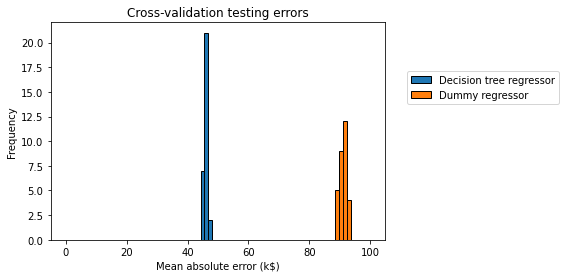

In [8]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.linspace(
    start=0,
    stop=100,
    num=80
)

all_errors.plot.hist(
    bins=bins,
    edgecolor="black"
)

plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")

plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Cross-validation testing errors")

##### QUIZ 1

**1. What the benefit of using cross-validation?**

a) Give information about performance variability

b) Remove the need to use a baseline algorithm

c) Give information regarding under- or over-fitting of a model 

<br>

**2. Does a dummy classifier or regressor rely on the input feature values in the input data X to make the predictions?**

a) Yes 

b) No

<br>

**3. Does a dummy classifier from scikit-learn always make constant predictions whatever the chosen strategy?**

a) Yes 

b) No


<br>



#### Choice of cross-validation 

In the previous notebooks, we always used either a default `KFold` or a `ShuffleSplit` cross-validation strategies to iteratively split our dataset. 

However, we should not assume that these approaches are always the best option: some other cross-validation strategies might be better adapted to your problem.

We discuss the other strategies and scenarios where they can be helpful in this section.


**Stratification**

We will start with the concept of Stratification by using an example of where we can get into trouble if we are not careful. 

We will load the iris dataset and create a basic machine-learning model: a logistic regression. 

We expect this model to work quite well on the iris dataset since this is a toy dataset.

Once we have created our model, we will use the cross-validation framework to evaluate it. 

We will use the `KFold` cross-validation strategy. 

We will define a toy dataset with nine samples, repeat the cross-validation three times (i.e. `n_splits`), and use three samples for testing and six for training each time by defining three splits, As KFold` does not shuffle by default. It will select the three first samples for the testing set at the first split, then the three next for the second split, and the three next for the last split. All samples will be used in testing at least once among the different splits.

After that, we apply the same `KFold` strategy to check the generalization performance of our model and get surprising results. We will observe that the target vector `target` is ordered and will have unexpected consequences when using the `KFold` cross-validation. 

We will show the class count in each cross-validation fold in the train and test set to illustrate the consequences. We will also compute the class counts for the training and testing sets using the `KFold` cross-validation and plot this information in a bar plot. We will iterate the given number of splits, check how many samples of each kind are present in the training and testing set, and store the information in two lists; one for the training set and one for the testing set.

We will observe that neither the training nor testing sets have the same class frequencies as our original dataset because each class's count varies slightly, and thus we get the unexpected results. 

However, one might want to split our data by preserving the original class frequencies: we want to **stratify** our data by class. 

In scikit-learn, *some cross-validation strategies implement the Stratification*, and they contain `Stratified` in their names.

Using stratified cross-validation, we will observe that the class counts are very close both in the train and test sets. The minuscule difference will be due to the small number of samples in the iris dataset.

<br>

**Lesson**

*Using Stratification within the cross-validation framework is a good practice when dealing with a classification problem.*


In [9]:
from sklearn.datasets import load_iris

data, target = load_iris(
    as_frame=True,
    return_X_y=True
)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

model


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [11]:
"""
Here we see how the KFold works internally, when we don't pass shuffle 
"""
import numpy as np
from sklearn.model_selection import KFold

data_random = np.random.randn(9, 1)

n_splits = 3

cv = KFold(
    n_splits=n_splits
)

for train_index, test_index in cv.split(data_random):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [3 4 5 6 7 8] TEST: [0 1 2]
TRAIN: [0 1 2 6 7 8] TEST: [3 4 5]
TRAIN: [0 1 2 3 4 5] TEST: [6 7 8]


In [12]:
from sklearn.model_selection import cross_validate

cv = KFold(
    n_splits=n_splits
)

results = cross_validate(
    model,
    data,
    target,
    cv=cv
)

test_score = results["test_score"]

"""
It is a real surprise that our model cannot correctly classify any sample in
any cross-validation split. 
We will now check our target's value to understand the issue.
"""

print(
    f"The average accuracy is "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}"
)

The average accuracy is 0.000 +/- 0.000


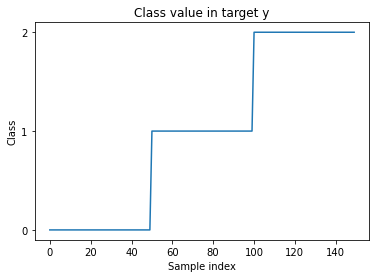

In [13]:
import matplotlib.pyplot as plt

target.plot()
plt.xlabel("Sample index")
plt.ylabel("Class")
plt.yticks(target.unique())
_ = plt.title("Class value in target y")

In [14]:
import pandas as pd


cv = KFold(
    n_splits=n_splits
)

train_cv_counts = []
test_cv_counts = []

for fold_idx, (train_idx, test_idx) in enumerate(cv.split(data, target)):

    target_train, target_test = target.iloc[train_idx], target.iloc[test_idx]

    train_cv_counts.append(target_train.value_counts())
    
    test_cv_counts.append(target_test.value_counts())

In [15]:
train_cv_counts = pd.concat(
    train_cv_counts,
    axis=1,
    keys=[f"Fold #{idx}" for idx in range(n_splits)]
)

train_cv_counts.index.name = "Class label"

train_cv_counts

,Fold #0,Fold #1,Fold #2
Class label,,,
1,50.0,NaN,50.0
2,50.0,50.0,NaN
0,NaN,50.0,50.0


In [16]:
test_cv_counts = pd.concat(
    test_cv_counts,
    axis=1,
    keys=[f"Fold #{idx}" for idx in range(n_splits)]
)

test_cv_counts.index.name = "Class label"

test_cv_counts

,Fold #0,Fold #1,Fold #2
Class label,,,
0,50.0,NaN,NaN
1,NaN,50.0,NaN
2,NaN,NaN,50.0


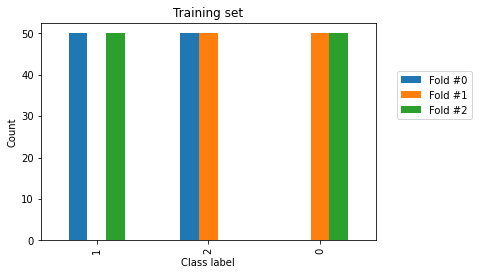

In [17]:
train_cv_counts.plot.bar()

plt.legend(
    bbox_to_anchor=(1.05, 0.8),
    loc="upper left"
)

plt.ylabel("Count")

_ = plt.title("Training set")

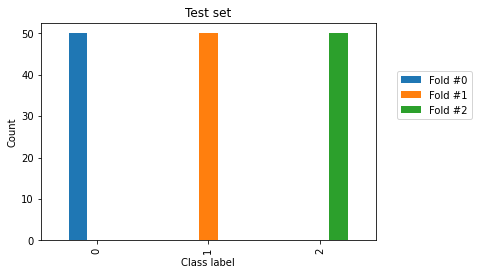

In [18]:
test_cv_counts.plot.bar()

plt.legend(
    bbox_to_anchor=(1.05, 0.8),
    loc="upper left"
)

plt.ylabel("Count")

_ = plt.title("Test set")

In [19]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(
    n_splits=n_splits
)

results = cross_validate(
    model,
    data,
    target,
    cv=cv
)

test_score = results["test_score"]

print(
    f"The average accuracy is "
    f"{test_score.mean():.3f} +/- {test_score.std():.3f}"
)

The average accuracy is 0.960 +/- 0.016


In [20]:
train_cv_counts = []
test_cv_counts = []

for fold_idx, (train_idx, test_idx) in enumerate(cv.split(data, target)):
    target_train, target_test = target.iloc[train_idx], target.iloc[test_idx]

    train_cv_counts.append(target_train.value_counts())
    test_cv_counts.append(target_test.value_counts())

train_cv_counts = pd.concat(
    train_cv_counts,
    axis=1,
    keys=[f"Fold #{idx}" for idx in range(n_splits)]
)

test_cv_counts = pd.concat(
    test_cv_counts,
    axis=1,
    keys=[f"Fold #{idx}" for idx in range(n_splits)]
)

train_cv_counts.index.name = "Class label"
test_cv_counts.index.name = "Class label"

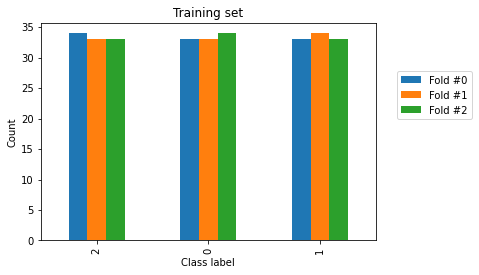

In [21]:
train_cv_counts.plot.bar()

plt.legend(
    bbox_to_anchor=(1.05, 0.8),
    loc="upper left"
)

plt.ylabel("Count")
_ = plt.title("Training set")

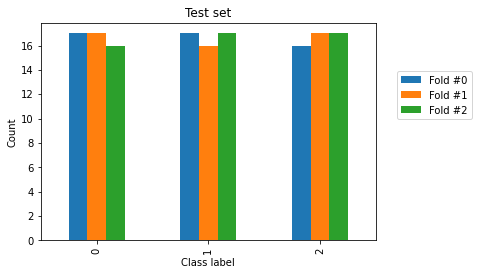

In [22]:
test_cv_counts.plot.bar()

plt.legend(
    bbox_to_anchor=(1.05, 0.8),
    loc="upper left"
)

plt.ylabel("Count")
_ = plt.title("Test set")

**Sample grouping**

We will linger into the concept of sample groups and use the handwritten digits dataset.

We will recreate the same model used in the previous section, a logistic regression classifier, but with a different preprocessor, i.e., MinMaxScaler, to scale the data.

We will use a `KFold` cross-validation without shuffling the data at first.

After that, we will repeat the experiment by shuffling the data within the
cross-validation. We will observe that shuffling the data improves the mean accuracy.

We will then plot the distribution of the testing score and observe that the cross-validation testing error that uses the shuffling has less variance than the one that does not impose any shuffling. In case of no shuffling, some specific fold leads to a low score. Thus, the data has an underlying structure that shuffling will break and get better results. 

<br>

When we dig in the documentation shipped with the dataset and read carefully, we will find that 13 writers wrote the digits of our dataset, accounting for 1797 samples. Thus, a writer wrote several times the same numbers. 

Let's suppose that the same writer's samples are grouped. Mixing the data will break this structure; therefore, digits written by the same writer will be available in both the training and testing sets. Subsequently, not shuffling the data will keep all writer samples together either in the training or the testing sets.

Besides, a writer usually tends to write digits similarly. Thus, our model will learn to identify a writer's pattern for each digit instead of recognizing it.


We can solve this problem by ensuring that the data associated with a writer should either belong to the training or the testing set. Thus, we want to group samples for each writer. Indeed, we can recover the groups by looking at the target variable.

<br>

It might not be evident at first, but there is a structure in the target: there is a repetitive pattern that always starts with some series of ordered digits from 0 to 9, followed by random digits at a certain point. 

If we look in detail, we see that there are 14 such patterns, always with around 130 samples each.

Even if it does not correspond precisely to the 13 writers in the documentation (maybe one writer wrote two series of digits), we can hypothesize that each pattern corresponds to a different writer and thus a different group.

<br>

Once we group the digits by writer, we can use cross-validation to take this information into account: the class containing `Group` should be used.

We see that this strategy is less optimistic regarding the model generalization performance. However, this is the most reliable if we aim to make handwritten digits recognition writers independent. 

<br>

**Lesson**

*It is essential to consider any sample grouping pattern when evaluating a model. Otherwise, the results obtained will be over-optimistic regarding reality.*

In [23]:
from sklearn.datasets import load_digits

digits = load_digits()

data, target = digits.data, digits.target



In [24]:
data.shape

(1797, 64)

In [25]:
target.shape

(1797,)

In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

"""
MinMaxScaler
This estimator scales and translates each feature individually such
that it is in the given range on the training set, e.g. between
zero and one.

The transformation is given by::

    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (max - min) + min

where min, max = feature_range.

This transformation is often used as an alternative to zero mean,
unit variance scaling.
"""
model = make_pipeline(
    MinMaxScaler(),
    LogisticRegression(max_iter=1_000)
)


In [27]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(
    shuffle=False
)

test_score_no_shuffling = cross_val_score(
    model,
    data,
    target,
    cv=cv,
    n_jobs=2
)

print(
    f"The average accuracy is "
    f"{test_score_no_shuffling.mean():.3f} +/- "
    f"{test_score_no_shuffling.std():.3f}"
)


The average accuracy is 0.931 +/- 0.026


In [28]:
cv = KFold(
    shuffle=True,
    random_state=42
)

test_score_with_shuffling = cross_val_score(
    model,
    data,
    target,
    cv=cv,
    n_jobs=2
)

print(
    f"The average accuracy is "
    f"{test_score_with_shuffling.mean():.3f} +/- "
    f"{test_score_with_shuffling.std():.3f}"
)


The average accuracy is 0.962 +/- 0.011


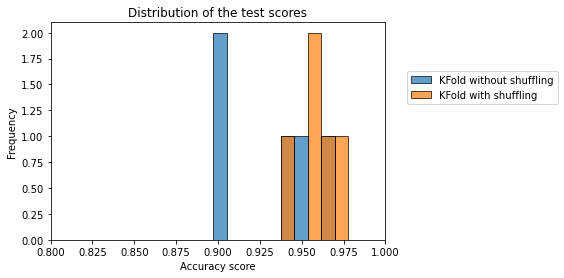

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling],
    index=["KFold without shuffling", "KFold with shuffling"],
).T


all_scores.plot.hist(
    bins=10,
    edgecolor="black",
    alpha=0.7
)

plt.xlim([0.8, 1.0])
plt.xlabel("Accuracy score")
plt.legend(
    bbox_to_anchor=(1.05, 0.8),
    loc="upper left"
)

_ = plt.title("Distribution of the test scores")

In [30]:
print(test_score_no_shuffling)
print(test_score_with_shuffling)


[0.94166667 0.89722222 0.94986072 0.9637883  0.90250696]
[0.96666667 0.97777778 0.96100279 0.96100279 0.94428969]


In [31]:

print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [32]:
target[:130]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7,
       7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6,
       6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 4,
       6, 3, 1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5,
       4, 4, 7, 2, 8, 2, 2, 5, 7, 9, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8])

In [33]:
target[130:256]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9, 8, 4, 1, 7,
       7, 3, 5, 1, 0, 0, 2, 2, 7, 8, 2, 0, 1, 2, 6, 3, 3, 7, 3, 3, 4, 6,
       6, 6, 4, 9, 1, 5, 0, 9, 5, 2, 8, 2, 0, 0, 1, 7, 6, 3, 2, 1, 7, 3,
       1, 3, 9, 1, 7, 6, 8, 4, 3, 1, 4, 0, 5, 3, 6, 9, 6, 1, 7, 5, 4, 4,
       7, 2, 8, 2, 2, 5, 5, 4, 8, 8, 4, 9, 0, 8, 9, 8])

In [34]:
from itertools import count
import numpy as np

# defines the lower and upper bounds of sample indices
# for each writer
writer_boundaries = [
    0, 130, 256, 386, 516, 646, 776, 915, 1029,
    1157, 1287, 1415, 1545, 1667, 1797
]

groups = np.zeros_like(target)

lower_bounds = writer_boundaries[:-1]
upper_bounds = writer_boundaries[1:]

for group_id, lb, up in zip(count(), lower_bounds, upper_bounds):
    groups[lb:up] = group_id

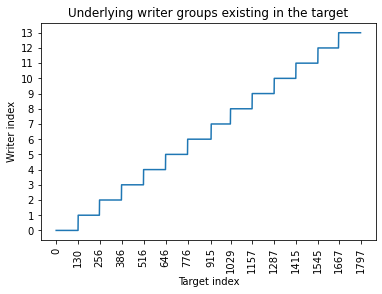

In [35]:
plt.plot(groups)
plt.yticks(np.unique(groups))
plt.xticks(writer_boundaries, rotation=90)
plt.xlabel("Target index")
plt.ylabel("Writer index")
_ = plt.title("Underlying writer groups existing in the target")

In [36]:
from sklearn.model_selection import GroupKFold

"""
K-fold iterator variant with non-overlapping groups.

The same group will not appear in two different folds (the number of
distinct groups has to be at least equal to the number of folds).

The folds are approximately balanced in the sense that the number of
distinct groups is approximately the same in each fold.
"""
cv = GroupKFold()

test_score = cross_val_score(
    model,
    data,
    target,
    groups=groups,
    cv=cv,
    n_jobs=2
)

"""
we can see that the standard deviation is reduced.
"""
print(
    f"The average accuracy is "
    f"{test_score.mean():.3f} +/- "
    f"{test_score.std():.3f}"
)

The average accuracy is 0.920 +/- 0.021


In [37]:
all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling, test_score],
    index=[
        "KFold without shuffling",
        "KFold with shuffling",
        "KFold with groups"
    ],
).T

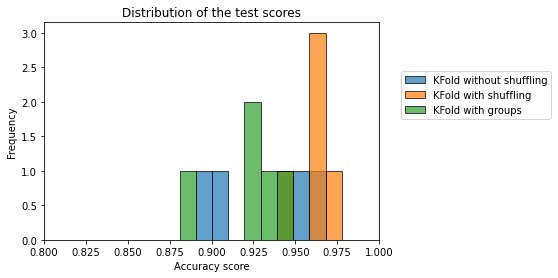

In [38]:
all_scores.plot.hist(
    bins=10,
    edgecolor="black",
    alpha=0.7
)

plt.xlim([0.8, 1.0])
plt.xlabel("Accuracy score")

plt.legend(
    bbox_to_anchor=(1.05, 0.8),
    loc="upper left"
)

_ = plt.title("Distribution of the test scores")

##### Non i.i.d. data

In machine learning, it is common to assume that the data are i.i.d, i.e. "independent and identically distributed" (independent and identically distributed random variables). 

*In simple terms, the generative process does not have any memory of past samples to generate new ones.*

**This assumption of independence is usually violated when dealing with time-series data**, where the sample depends on past information - like stock market data.

<br>

We will use financial quotations from some energy companies to demonstrate how to work with non-i.i.d data. We use financial data for  "Total", "Exxon", "Chevron", "ConocoPhillips", and "Valero Energy". 

Here our goal is to predict the quotation of Chevron using all other energy companies' quotes. 

We will start by plotting the financial quotations for these companies to see how they have a relation in variation and also has a time series component.

We first use a train-test split and then evaluate other cross-validation methods.

We will **use a decision tree regressor that we expect to overfit and thus not generalize to unseen data** and then use ShuffleSplit cross-validation to check the generalization performance of our model.

We previously mentioned that ShuffleSplit is an iterative cross-validation scheme that shuffles data and then splits the data. 

This step breaks any "time series" pattern in the data, but surprisingly, we get outstanding generalization performance. 

Thus we will investigate the reason for such good results with a model we expected to fail. 

<br>

We will simplify this procedure with a single split and plot the prediction. We will use train_test_split for this purpose and check the generalization performance of our model on this split.

We will again obtain good results in terms of $R^2$. 

<br>

We will plot the training, testing, and prediction samples and notice that the model predictions follow the testing. But we can also see that the testing samples are next to some training samples. 

And with the given time series, we see a relationship between the sample at the time t and a sample at time t+1. 

In this case, we are violating the i.i.d. assumption. 

The insight is that a model can output its training set at the time t for a testing sample at the time t+1. 

*This prediction would be close to the true value even if our model did not learn anything but just memorized the training dataset.*

<br>

An easy way to verify this hypothesis is not to shuffle the data when doing the split. In this case, we will use the first 75% of the data to train and the remaining data to test. 


We will see that our model is not magical anymore. Indeed, it performs worse than just predicting the mean of the target. We can visually check what we are predicting.

We observe that our model cannot predict anything because it doesn't have samples around the testing sample. 

<br>

**How could we have made a proper cross-validation scheme to get a reasonable generalization performance estimate?**

* One solution would be to group the samples into time blocks, e.g., by quarter, and to predict each group's information using information from the other groups. 

    We can use the LeaveOneGroupOut cross-validation for this purpose and see that we cannot make good predictions, which is less surprising than our original results.


*   Another thing to consider is the actual application of our solution. 

    If our model is aimed at forecasting (i.e., predicting future data from past data), **we should not use training data that are ulterior to the testing data**. In this case, we can use the `TimeSeriesSplit` cross-validation to enforce this behavior.

<br>

**Lesson**

It is essential not to use an out-of-the-shelves cross-validation strategy that does not respect some assumptions, such as having i.i.d data. It might lead to absurd results, which could make think that a predictive model might work.


In [39]:
import pandas as pd

symbols = {
    "TOT": "Total",
    "XOM": "Exxon",
    "CVX": "Chevron",
    "COP": "ConocoPhillips",
    "VLO": "Valero Energy"
}

template_name = ("../datasets/FD/{}.csv")

quotes = {}
for symbol in symbols:
    data = pd.read_csv(
        template_name.format(symbol), index_col=0, parse_dates=True
    )
    quotes[symbols[symbol]] = data["open"]
quotes = pd.DataFrame(quotes)

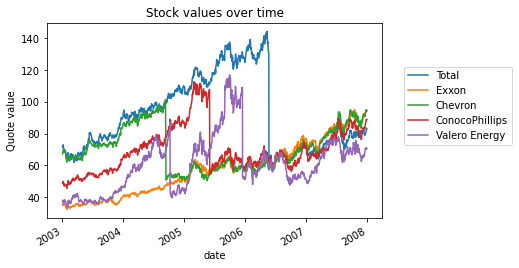

In [40]:
import matplotlib.pyplot as plt

quotes.plot()
plt.ylabel("Quote value")

plt.legend(
    bbox_to_anchor=(1.05, 0.8),
    loc="upper left"
)

_ = plt.title("Stock values over time")

In [41]:
from sklearn.model_selection import train_test_split

data, target = quotes.drop(columns=["Chevron"]),quotes["Chevron"]

data_train, data_test, target_train, target_test = train_test_split(
    data,
    target,
    shuffle=True,
    random_state=42
)

In [42]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

regressor = DecisionTreeRegressor()

cv = ShuffleSplit(
      random_state=42
)

test_score = cross_val_score(
      regressor,
      data_train,
      target_train,
      cv=cv,
      n_jobs=2
)

print(
      f"The mean R2 is: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}"
)


The mean R2 is: 0.96 +/- 0.07


In [43]:
regressor.fit(
    data_train,
    target_train
)

target_predicted = regressor.predict(data_test)

# Affect the index of `target_predicted` to ease the plotting
target_predicted = pd.Series(target_predicted, index=target_test.index)

In [44]:
from sklearn.metrics import r2_score

test_score = r2_score(
    target_test,
    target_predicted
)

print(
    f"The R2 on this single split is: {test_score:.2f}"
)

The R2 on this single split is: 0.85


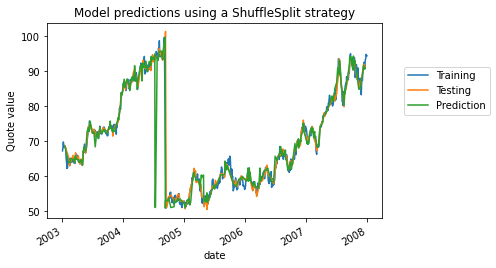

In [45]:
target_train.plot(label="Training")

target_test.plot(label="Testing")

target_predicted.plot(label="Prediction")

plt.ylabel("Quote value")

plt.legend(
    bbox_to_anchor=(1.05, 0.8),
    loc="upper left"
)

_ = plt.title("Model predictions using a ShuffleSplit strategy")

In [46]:
data_train, data_test, target_train, target_test = train_test_split(
    data,
    target,
    shuffle=False,
    random_state=42,
)

regressor.fit(
    data_train,
    target_train
)

target_predicted = regressor.predict(
    data_test
)

target_predicted = pd.Series(
    target_predicted,
    index=target_test.index
)

test_score = r2_score(
    target_test,
    target_predicted
)

print(f"The R2 on this single split is: {test_score:.2f}")

The R2 on this single split is: -2.38


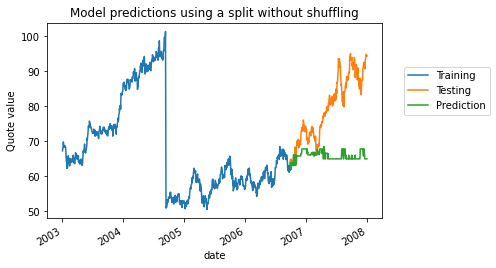

In [47]:
target_train.plot(label="Training")
target_test.plot(label="Testing")
target_predicted.plot(label="Prediction")

plt.ylabel("Quote value")

plt.legend(
    bbox_to_anchor=(1.05, 0.8),
    loc="upper left"
)

_ = plt.title("Model predictions using a split without shuffling")

In [48]:
from sklearn.model_selection import LeaveOneGroupOut

groups = quotes.index.to_period("Q")

"""
Leave One Group Out cross-validator

Provides train/test indices to split data according to a third-party
provided group. This group information can be used to encode arbitrary
domain specific stratifications of the samples as integers.

For instance the groups could be the year of collection of the samples
and thus allow for cross-validation against time-based splits.
"""
cv = LeaveOneGroupOut()

test_score = cross_val_score(
      regressor,
      data,
      target,
      cv=cv,
      groups=groups,
      n_jobs=2
)

print(
      f"The mean R2 is: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}"
)


The mean R2 is: -0.80 +/- 1.60


In [49]:
from sklearn.model_selection import TimeSeriesSplit

"""
Time Series cross-validator

Provides train/test indices to split time series data samples
that are observed at fixed time intervals, in train/test sets.
In each split, test indices must be higher than before, and thus shuffling
in cross validator is inappropriate.

This cross-validation object is a variation of :class:`KFold`.
In the kth split, it returns first k folds as train set and the
(k+1)th fold as test set.

Note that unlike standard cross-validation methods, successive
training sets are supersets of those that come before them.

"""

cv = TimeSeriesSplit(
      n_splits=groups.nunique()
)

test_score = cross_val_score(
      regressor,
      data,
      target,
      cv=cv,
      groups=groups,
      n_jobs=2
)

print(
      f"The mean R2 is: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}"
)


The mean R2 is: -2.32 +/- 3.42


##### QUIZ 2

**1. Given a dataset containing records from patients in 10 different hospitals, we would like to predict if a patient has a disease or not. We suspect that different hospitals can have systematic biases in their respective populations (age, socioeconomic status, genetics...). Which cross-validation strategies are the most adequate to evaluate the ability of the model to make good predictions on patients from unseen hospitals?**


a) Group stratified k-fold cross-validation

b) Group k-fold

c) Stratified k-fold cross-validation 

d) Leave-one-out cross-validation

<br>

#### Nested Cross-validation 

We can use Cross-validation for the hyperparameter tuning and estimating a model's generalization performance. 

However, simultaneously using it for both purposes is problematic, as the resulting evaluation can underestimate some overfitting resulting from the hyperparameter tuning procedure itself.

Philosophically, hyperparameter tuning is a form of machine learning
itself, and therefore, we need another outer loop of cross-validation to evaluate the generalization performance of the full modeling procedure properly.

<br>

In this section, we revisit the nested cross-validation and understand its impact on the estimated generalization performance compared to naively using a single level of cross-validation. We will do this for the hyperparameter tuning and evaluation of the generalization performance and use the breast cancer dataset.

First, we will use `GridSearchCV` to find the best parameters via cross-validation on a minimal parameter grid.

We recall that, internally, **`GridSearchCV` trains several models for each on sub-sampled training sets and evaluates them on the matching testing set using cross-validation**. This evaluation procedure is controlled via using the `cv` parameter. The procedure is then repeated for all possible combinations of parameters given in `param_grid`.

The attribute `best_params_` gives us the best parameters that maximize the mean score on the internal test sets. 

*At this stage, one should be extremely careful using the score calculated. The misinterpretation would be the following: since this mean score was computed using cross-validation test sets, we could use it to assess the generalization performance of the model trained with the best hyper-parameters. However, we should not forget that we used this score to pick the best model. It means that we used knowledge from the test sets (i.e., test scores) to select the hyper-parameter of the model itself. Thus, the mean score is not a fair estimate of our testing error.*

Indeed, it can be too optimistic, particularly when running a parameter search on a large grid with many hyper-parameters and possible values per hyper-parameter. 

*A way to avoid this pitfall is to use a "nested" cross-validation.*

<br>

We will use an inner cross-validation corresponding to the previous procedure above to only optimize the hyperparameters. We will also embed this tuning procedure within outer cross-validation, which is dedicated to estimate the testing error of our tuned model.

In this case, our inner cross-validation gets the training set of the outer cross-validation, making it possible to always compute the final testing scores on completely independent sets of samples.

We will observe that the generalization performance estimated without nested CV is higher than what we obtain with nested CV. The reason is that the tuning procedure selects the model with the highest inner CV score. 

If there are many hyper-parameter combinations, and if the inner CV scores have comparatively large standard deviations, taking the maximum value can lure the naive data scientist into overestimating the true generalization performance of the result of the full learning procedure. 

**By using an outer cross-validation procedure, one gets a more trustworthy estimate of the generalization performance of the full learning procedure, including the effect of tuning the hyperparameters.**


Notice that our inner cross-validation will always get the training set of the outer cross-validation, making it possible always to compute the final testing scores on entirely independent sets of samples.

The reported score will be more trustworthy and should be close to the production's expected generalization performance. 

<br>

However, we would like to assess the difference between the nested and better non-nested cross-validation scores to show that the latter can be too optimistic in practice. To do this, we will repeat the experiment several times and shuffle the data differently to ensure that our conclusion does not depend on a particular data resampling.


We will observe that the generalization performance estimated without nested CV is higher than what we obtain with nested CV. The reason is that the tuning procedure selects the model with the highest inner CV score. If there are many hyper-parameter combinations and the inner CV scores have comparatively large standard deviations, taking the maximum value can lure the naive data scientist into overestimating the true generalization performance of the result of the full learning procedure. 


By using an outer cross-validation procedure one gets a more trustworthy estimate of the generalization performance of the full learning procedure, including the effect of tuning the hyperparameters.

<br>

**Lesson**

When optimizing parts of the machine learning pipeline (e.g. hyperparameter, transform, etc.), one needs to use nested cross-validation to evaluate the generalization performance of the predictive model. Otherwise, the results obtained without nested cross-validation are often overly optimistic.




In [50]:
from sklearn.datasets import load_breast_cancer

data, target = load_breast_cancer(
    return_X_y=True
)

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    "C": [0.1, 1, 10],
    "gamma": [.01, .1]
}

model_to_tune = SVC()

search = GridSearchCV(
    estimator=model_to_tune,
    param_grid=param_grid,
    n_jobs=2
)

search.fit(data, target)

GridSearchCV(estimator=SVC(), n_jobs=2,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1]})

In [52]:
print(f"The best parameters found are: {search.best_params_}")
print(f"The mean CV score of the best model is: {search.best_score_:.3f}")

The best parameters found are: {'C': 0.1, 'gamma': 0.01}
The mean CV score of the best model is: 0.627


In [53]:
from sklearn.model_selection import cross_val_score, KFold

# Declare the inner and outer cross-validation strategies
inner_cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

outer_cv = KFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=model_to_tune,
    param_grid=param_grid,
    cv=inner_cv,
    n_jobs=2
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(
    model,
    data,
    target,
    cv=outer_cv,
    n_jobs=2
)

print(
    f"The mean score using nested cross-validation is: "
    f"{test_score.mean():.3f} +/- {test_score.std():.3f}"
)

The mean score using nested cross-validation is: 0.626 +/- 0.020


In [54]:
test_score_not_nested = []
test_score_nested = []

N_TRIALS = 20
for i in range(N_TRIALS):
    # For each trial, we use cross-validation splits on independently
    # randomly shuffled data by passing distinct values to the random_state
    # parameter.
    inner_cv = KFold(
        n_splits=5,
        shuffle=True,
        random_state=i
    )

    outer_cv = KFold(
        n_splits=3,
        shuffle=True,
        random_state=i
    )

    # Non_nested parameter search and scoring
    model = GridSearchCV(
        estimator=model_to_tune,
        param_grid=param_grid,
        cv=inner_cv,
        n_jobs=2
    )

    model.fit(
        data,
        target
    )
    
    test_score_not_nested.append(model.best_score_)

    # Nested CV with parameter optimization
    test_score = cross_val_score(
        model,
        data,
        target,
        cv=outer_cv,
        n_jobs=2
    )

    test_score_nested.append(
        test_score.mean()
    )

In [55]:
import pandas as pd

all_scores = {
    "Not nested CV": test_score_not_nested,
    "Nested CV": test_score_nested,
}
all_scores = pd.DataFrame(all_scores)

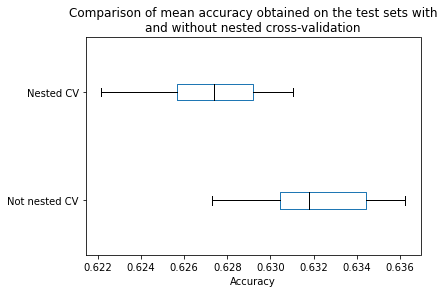

In [56]:
import matplotlib.pyplot as plt

color = {
    "whiskers": "black",
    "medians": "black",
    "caps": "black"
}

all_scores.plot.box(
    color=color,
    vert=False
)

plt.xlabel("Accuracy")
_ = plt.title(
    "Comparison of mean accuracy obtained on the test sets with\n"
    "and without nested cross-validation"
)

##### QUIZ 3

**1. How to evaluate and tune the hyperparameters of a model?**

a) Fit the model on the train set, set the parameters using the test set, and evaluate the model on the same test set 

b) Fit the model on the train set, set the parameters using a validation set, and evaluate the model on the test set 

c) use a nested cross-validation, with an inner cross-validation to tune the parameters of the model and an outer cross-validation to evaluate the model's performance

<br>


#### Classification Metrics

Machine learning models rely on optimizing an objective function by seeking its minimum or maximum. Understanding that this objective function is usually decoupled from the evaluation metric we want to optimize in practice is essential. 

The objective function serves as a proxy for the evaluation metric. 
This section gives an overview of the classification metrics we can use to evaluate the predictive model generalization performance. 

We have picked a data which has multiple classes to demonstrate how to deal with multiclass problems. 




In [57]:

from sklearn.datasets import load_wine

X, y = load_wine(as_frame=True, return_X_y=True)

print(X.shape)
print(y.shape)


(178, 13)
(178,)


In [58]:
print(X.columns)

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')


In [59]:
import numpy as np
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([59, 71, 48]))

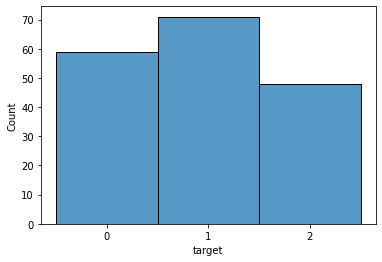

In [60]:
import seaborn as sns
import pandas as pd

_ = sns.histplot(
    data=y.astype('str').to_frame(),
    x='target',
    discrete=1
)


In [61]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    X,
    y,
    shuffle=True,
    random_state=42, 
    test_size=0.5
)

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# we set parameter of LogisticRegression such that it doesn't give great results
clf = Pipeline(
    (
        ['scale', StandardScaler()],
        ['classify', LogisticRegression(penalty='l1', C=0.05, solver='saga', max_iter=5000)]
    )
)

clf.fit(
    data_train,
    target_train
)

Pipeline(steps=[('scale', StandardScaler()),
                ['classify',
                 LogisticRegression(C=0.05, max_iter=5000, penalty='l1',
                                    solver='saga')]])

In [63]:
"""
In this comparison a True value means that the value predicted by our classifier is identical to the real value, 
while a False means that our classifier made a mistake. 
"""
target_predicted = clf.predict(data_test)

np.unique(
    target_predicted==target_test,
    return_counts=True
)



(array([False,  True]), array([14, 75]))

In [64]:
"""
One way of getting an overall rate representing the generalization performance of our classifier 
would be to compute how many times our classifier was right and divide it by the number of samples in our set.
"""
np.mean(target_test == target_predicted)

0.8426966292134831

In [65]:
"""
The above measure is called the accuracy. 
Here, our classifier is 78% accurate at classifying. 
scikit-learn provides a function that computes this metric in the module sklearn.metrics.
"""
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(target_test, target_predicted)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.843


In [66]:
"""
LogisticRegression also has a method named score (part of the standard scikit-learn API), 
which computes the accuracy score.
"""
clf.score(data_test, target_test)

0.8426966292134831

##### Confusion matrix and derived metrics

The comparison we did above and the Accuracy that we calculated did not consider the type of error our classifier was making. 

Accuracy is an aggregate of the errors made by the classifier. 

We may be interested in finer granularity - to know the error for each class independently. 

**Confusion Matrix**
A Confusion matrix is an $ N x N $  matrix used to evaluate a classification model's performance, where $N$ is the number of target classes. The matrix compares the actual target values with those predicted by the machine learning model, which gives us a holistic view of how well our classification model performs and what kinds of errors it makes.

For a binary classification problem, we would have a $ 2 x 2 $ matrix as shown below with 4 values:

![basic confusion matrix](../figures/confusion/Confusion-matrix.png)

<br>

Terminology from a confusion matrix

**condition Positive (P)**  the number of real positive cases in the data

**condition negative (N)**  the number of real negative cases in the data

**True Positive (TP)**  A test result that correctly indicates the presence of a condition or characteristic

**True Negative (TN)**  A test result that correctly indicates the absence of a condition or characteristic

**False positive (FP)**  A test result that wrongly indicates that a particular condition or attribute is present

**False Negative (FN)** A test result that wrongly indicates that a particular condition or attribute is absent

<br>
Now we walk through some visual examples to understand the concept properly. 
Assume we have 10 photos, and exactly 7 of them have dogs. 
If our classifier were perfect, the confusion matrix would look like this:

![perfect 2x2](../figures/confusion/2_1.png)

This perfect classifier classified all positive photos and Positive and all negative as Negative.


In the real world, however, classifiers make errors. A binary classifier makes two errors: some Positive samples are classified as Negative, and some Negative samples are classified as Positive. 

![real 2x2](../figures/confusion/2_2.png)

In this example, 2 photos with dogs were classified as Negative (no dog!), and 1 photo without a dog was classified as Positive (dog!).

When a Positive sample is falsely classified as Negative, we call this a False Negative (FN). 

And similarly, when a Negative sample is falsely classified as a Positive, it is called a False Positive. 

Below is the same confusion matrix, but we added TP, FP, FN, and TN to designate the True Positive, False Position, False Negative, and True Negative values.

![real 2x2 with error terminology](../figures/confusion/2_3.png)

**Precision**
What proportion of predicted Positives is truly Positive? 

We need to look at the total number of predicted Positives (the True Positives plus the False Positives, TP+FP) and see how many of them are True Positive (TP). 

In our case, 5+1=6 photos were predicted as Positive, but only 5 of them were True Positives. The Precision in our case is thus 5/(5+1)=83.3%. 
In general, Precision is TP/(TP+FP). Note that TP+FP is the sum of the first row.

**Recall**
what proportion of actual Positives is correctly classified? 

We know that the number of actual Positives is 2+5=7 (TP+FN). Out of these 7 photos, 5 were predicted as Positive. The recall is thus 5/7 = 71.4%. 
In general, recall is TP/(TP+FN). Note that TP+FN is the sum of the first column.

**Accuracy**
what proportion of photos — both Positive and Negative — were correctly classified? 

In our case, 5+2=7 of the photos were correctly classified out of 10. Thus, the Accuracy is 70.0%. 
Generally speaking, there are a total of TP+TN correctly classified photos out of TP+TN+FP+FN photos, so the general formula for Accuracy is (TP+TN)/(TP+TN+FP+FN).

<br>

Now we look at a multiclass classification example. 

we have total three classes which can be either a cat, a fish, or a hen and the sample confusion matrix that is produced after classifying 25 photos

![real 3x3](../figures/confusion/3_1.png)

Similar to our binary case, we can define precision and recall for each class. 

The precision for the Cat class is the number of correctly predicted Cat photos (4) out of all predicted Cat photos (4+3+6=13), which amounts to 4/13=30.8%. 

The recall for Cat is the number of correctly predicted Cat photos (4) out of the number of actual Cat photos (4+1+1=6), which is 4/6=66.7%. 

![real 3x3 cat precison and recall](../figures/confusion/3_2.png)

<br>

We can also calculate the precision and recall for the other two classes: Fish and Hen. 

For Fish the numbers are 66.7% and 20.0%, respectively.
 
For Hen the number for both precision and recall is 66.7%. 

![real 3x3 fish](../figures/confusion/3_3.png)

<br>

![real 3x3 hen](../figures/confusion/3_4.png)

<br>

we can compute the macro-averaged precision and the macro-averaged recall:

Macro-precision = (31% + 67% + 67%) / 3 = 54.7%

Macro-recall = (67% + 20% + 67%) / 3 = 51.1%

<br>

we can also compute weighted precision and weighted recall:

Weighted-precision=(6 × 30.8% + 10 × 66.7% + 9 × 66.7%)/25 = 58.1%

Weighted-recall = (6 × 66.7% + 10 × 20.0% + 9 × 66.7%) / 25 = 48.0%

<br>

Below is an image that shows the different metrics derived from the above terms.

![confusion derivatives](../figures/confusion/confusion_derivaties.png)

<br>


**Accuracy: how many times is the model right overall**

**Precision: how many [specific category] predictions were correct?**

**Recall: How many times were [specific category] correctly classified**

scikit-learn provides functions to compute these statistics.

<br>

Now that we have learned the essential concept, we will generate the confusion matrix for our wine data.

The in-diagonal numbers are related to correct predictions, while off-diagonal numbers are related to incorrect predictions (misclassifications). 

Once we have split this class-based information, we can compute metrics to highlight the generalization performance of our classifier in a particular setting. 

<br>


[source](https://en.wikipedia.org/wiki/Confusion_matrix)

[source](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2)


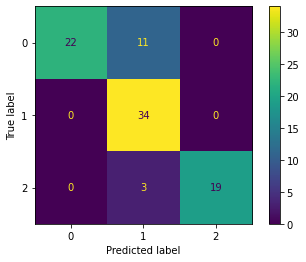

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay.from_estimator(
    clf,
    data_test,
    target_test
)


In [68]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(target_test, target_predicted, average=None)
recall = recall_score(target_test, target_predicted,average=None)

print("\n------\n")
print("average : None")
print(f"Precision score: {precision}")
print(f"Recall score: {recall}")
print("\n------\n")

precision = precision_score(target_test, target_predicted, average='macro')
recall = recall_score(target_test, target_predicted, average='macro')

print("average : macro")
print(f"Precision score: {precision}")
print(f"Recall score: {recall}")
print("\n------\n")

precision = precision_score(target_test, target_predicted, average='weighted')
recall = recall_score(target_test, target_predicted, average='weighted')

print("average : weighted")
print(f"Precision score: {precision}")
print(f"Recall score: {recall}")
print("\n------\n")


------

average : None
Precision score: [1.         0.70833333 1.        ]
Recall score: [0.66666667 1.         0.86363636]

------

average : macro
Precision score: 0.9027777777777778
Recall score: 0.8434343434343434

------

average : weighted
Precision score: 0.8885767790262173
Recall score: 0.8426966292134831

------



In [69]:
from sklearn.metrics import classification_report

print(classification_report(target_test, target_predicted, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.667     0.800        33
           1      0.708     1.000     0.829        34
           2      1.000     0.864     0.927        22

    accuracy                          0.843        89
   macro avg      0.903     0.843     0.852        89
weighted avg      0.889     0.843     0.843        89



##### The issue of class imbalance


As we mentioned, precision and recall only focuses on samples predicted to be positive, while accuracy takes both into account. 

In addition, we did not look at the ratio of classes (labels). 

We could check this ratio in the training set.

We can use dummy classifier as a baseline.

With the dummy classifier we obtain an accuracy score of 38%. Therefore, it means that this classifier, without learning anything from the data data, is capable of predicting with 40% accuracy

When the classes are imbalanced, accuracy should not be used and one should either use the precision and recall as presented above or the balanced accuracy score instead of accuracy.

The balanced accuracy is equivalent to accuracy in the context of balanced classes. 

It is defined as the average recall obtained on each class.


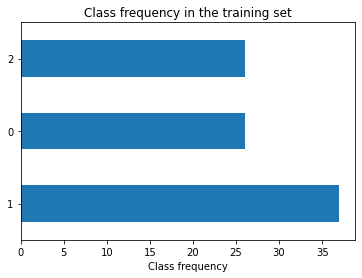

In [70]:
target_train.value_counts(normalize=False).plot.barh()

plt.xlabel("Class frequency")

_ = plt.title("Class frequency in the training set")

In [71]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(
      strategy="most_frequent"
)

dummy_classifier.fit(
      data_train,
      target_train
)

print(
      f"Accuracy of the dummy classifier: "
      f"{dummy_classifier.score(data_test, target_test):.3f}"
)

Accuracy of the dummy classifier: 0.382


In [72]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy = balanced_accuracy_score(
    target_test,
    target_predicted
)

print(
    f"Balanced accuracy: {balanced_accuracy:.3f}"
)

Balanced accuracy: 0.843


##### Evaluation and different probability thresholds

Another thing to consider in multiclass classification is OvR and OvO

OvR — One vs. Rest

OvR stands for "One vs. Rest". In this method, we evaluate multiclass models by comparing each class against the others simultaneously. We take one class and consider it as our "positive" class, while all the others (the rest) are considered as the "negative" class.

By doing this, we reduce the multiclass classification output into a binary classification one. So it is possible to use all the known binary classification metrics to evaluate this scenario.

We must repeat this for each class present on the data, so for a 3-class dataset, we get three different OvR scores. Ultimately, we can average them (simple or weighted average) to have a final OvR model score.

![OvR](../figures/confusion/m_o_v_r.png)

<br>

OvO — One vs. One

OvO stands for "One vs. One". Instead of comparing each class with the rest, this method compares all possible two-class combinations of the dataset.

The first step is to get a copy of the dataset containing only the two classes and discard all the others. Let's say we have a 3-class scenario and choose the combination "Class1 vs. Class2" as the first. Then we define observations with real class = "Class1" as our positive class and the ones with real class = "Class2" as our negative class. Now that the problem is binary, we can use the same metrics we use for binary classification.

Note that "Class1 vs. Class2" is different than "Class2 vs. Class1", so both cases should be accounted. Because of that, in a 3-class dataset, we get 6 OvO scores; in a 4-class dataset, we get 12 OvO scores.

As in OvR, we can average all the OvO scores to get a final OvO model score.


![OvO](../figures/confusion/m_o_v_o.png)

<br>

All statistics we presented now rely on the `classifier.predict` which outputs the most likely label. We haven’t used the probability associated with this prediction, which gives the classifier confidence in this prediction. 

The precision-recall curve does not support the multilabel setting. However, one can decide how to handle this case. We use OneVsRestClassifier for multi-label prediction.

On this curve, each blue cross corresponds to a level of probability which we used as a decision threshold. We can see that we get different precision vs. recall values by varying this decision threshold.

A perfect classifier would have a precision of 1 for all recall values. A metric characterizing the curve is linked to the area under the curve (AUC) and called average precision (AP). With an ideal classifier, the average precision would be 1.

The precision and recall metric focuses on the positive class. However, one might be interested in the compromise between accurately discriminating the positive class and accurately discriminating the negative classes. 

The statistics used for this are sensitivity and specificity. Sensitivity is just another name for recall. However, specificity measures the proportion of correctly classified samples in the negative class defined as TN / (TN + FP). 

Similar to the precision-recall curve, sensitivity and specificity are generally plotted as a curve called the receiver operating characteristic (ROC) curve. This curve was built using the same principle as the precision-recall curve: we vary the probability threshold for determining “hard” prediction and compute the metrics. 

As with the precision-recall curve, we can compute the area under the ROC (ROC-AUC) to characterize the generalization performance of our classifier. 

<br>

[source](https://www.pythonfixing.com/2022/01/fixed-how-to-plot-precision-and-recall.html)


[source](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)


[source](https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a)



In [73]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

n_classes = len(set(y.values))
print(f"number of classes is {n_classes}")

y_b = label_binarize(y.values, classes=[*range(n_classes)])

print(f"type of y_binarised is {type(y_b)}")
print(f"type of X.values is {type(X.values)}")



number of classes is 3
type of y_binarised is <class 'numpy.ndarray'>
type of X.values is <class 'numpy.ndarray'>


In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y_b,
    random_state=42,
    test_size=0.6
)

clf_b = OneVsRestClassifier(
    clf
)

clf_b.fit(
    X_train,
    y_train
)

target_predicted = clf_b.predict(X_test)

target_proba_predicted = clf_b.predict_proba(
    X_test
)

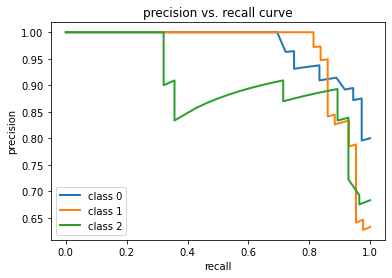

In [75]:
from sklearn.metrics import precision_recall_curve, roc_curve

precision = dict()
recall = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        y_test[:, i],
        target_proba_predicted[:, i]
    )

    plt.plot(
        recall[i],
        precision[i],
        lw=2,
        label='class {}'.format(i)
    )
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()



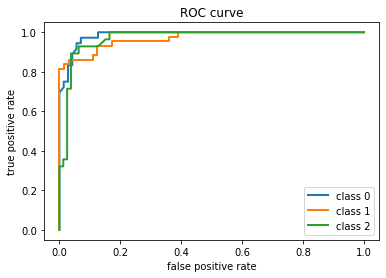

In [76]:
# roc curve
fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(
        y_test[:, i],
        target_proba_predicted[:, i]
    )
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

##### QUIZ 4

**1. What is the default score in scikit-learn when using a classifier?**

a) balanced accuracy

b) ROC-AUC

c) accuracy

<br>

**2. Other than the decision threshold, metrics such as recall and precision also depend on the regularization parameters.**

![question_2](../figures/quiz4_q2.png)

**Assuming that class "1" (in red) is the positive class, use the previous figures to select which statements are true in this particular logistic regression model.**

a) stronger regularization leads to higher precision

b) stronger regularization leads to lower precision

c) stronger regularization leads to higher recall 

d) stronger regularization leads to lower recall

<br>



#### Regression Metrics

In this section, we will present the metrics used in the regression.

We can not use classification metrics to evaluate the generalization performance of regression models because there is a fundamental difference between their target type target: a continuous variable in regression and a discrete variable in classification.

<br>

Some machine learning models are designed to be solved as an optimization problem: minimizing an error (also known as the loss function) using a training set. 

A basic loss function used in regression is the mean squared error (MSE). Thus, this metric is sometimes used to evaluate the model since said model optimizes it.

<br>

We will use a linear regression model for demonstration purposes and a "refined" ames housing data set.

Our linear regression model minimizes the mean squared error on the training set. *It means that no other set of coefficients will decrease the error.*

Then, we compute the mean squared error on the test set.

The raw MSE can be challenging to interpret. One way is to rescale the MSE by the variance of the target. This score is known as the $R^2$ also called the coefficient of determination. 

Indeed, this is the default score used in scikit-learn by calling the method score.


The $R^2$  score represents the proportion of variance of the target explained by the model's independent variables. The best score possible is 1, but it has no lower bound. 

However, a model that predicts the expected value of the target would get a score of 0.

The $R^2$ score gives insight into the quality of the model's fit. 

However, we cannot compare $R^2$ from one dataset to another, and the value obtained does not have a meaningful interpretation relative to the original unit of the target. 

<br>

We would be interested in the median or mean absolute error to get an interpretable score.

By computing the mean absolute error, we can interpret that our model predicts, on average 22.572 k$ away from the true house price. A disadvantage of this metric is that a large error can impact the mean. 

We might not want large errors to influence our metric significantly for some applications. In that case, we can use the median absolute error.

The mean absolute error (or median absolute error) still has a known limitation: committing an error of 50 k$ for a house valued at 50 k$ has the same impact as committing an error of 50 k$ for a house valued at 500 k$. 

Indeed, the mean absolute error is not relative.

<br>

**The mean absolute percentage error introduces this relative scaling.**

In addition to metrics, we can visually represent the results by plotting the predicted values versus the true values.

We generate a plot where the correct predictions lie on the diagonal line. This plot allows us to detect if the model consistently makes errors, i.e., has some bias.

<br>

We see in the plot that our model tends to underestimate the house price for the large True price values. Typically, this issue arises when the predicted target does not follow a normal distribution. 

In this case, the model would benefit from target transformation.

Thus, once we transformed the target, we see that we corrected some of the high values.



In [77]:

import pandas as pd
import numpy as np

ames_housing = pd.read_csv("../datasets/house_prices.csv")
ames_housing = ames_housing.drop(columns="Id")

X = ames_housing.drop(columns="SalePrice")
y = ames_housing["SalePrice"]
X = X.select_dtypes(np.number)
y /= 1000

print(X.shape)
print(y.shape)


(1460, 33)
(1460,)


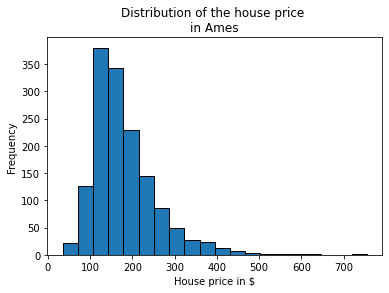

In [78]:
import matplotlib.pyplot as plt
y.plot.hist(bins=20, edgecolor="black")
plt.xlabel("House price in $")
_ = plt.title("Distribution of the house price \nin Ames")

In [79]:
X.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,8450,7,5,2003,2003,706,0,150,856,...,548,0,61,0,0,0,0,0,2,2008
1,20,9600,6,8,1976,1976,978,0,284,1262,...,460,298,0,0,0,0,0,0,5,2007
2,60,11250,7,5,2001,2002,486,0,434,920,...,608,0,42,0,0,0,0,0,9,2008
3,70,9550,7,5,1915,1970,216,0,540,756,...,642,0,35,272,0,0,0,0,2,2006
4,60,14260,8,5,2000,2000,655,0,490,1145,...,836,192,84,0,0,0,0,0,12,2008


In [80]:
y.head()

0    208.5
1    181.5
2    223.5
3    140.0
4    250.0
Name: SalePrice, dtype: float64

In [81]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   MSSubClass     1460 non-null   int64
 1   LotArea        1460 non-null   int64
 2   OverallQual    1460 non-null   int64
 3   OverallCond    1460 non-null   int64
 4   YearBuilt      1460 non-null   int64
 5   YearRemodAdd   1460 non-null   int64
 6   BsmtFinSF1     1460 non-null   int64
 7   BsmtFinSF2     1460 non-null   int64
 8   BsmtUnfSF      1460 non-null   int64
 9   TotalBsmtSF    1460 non-null   int64
 10  1stFlrSF       1460 non-null   int64
 11  2ndFlrSF       1460 non-null   int64
 12  LowQualFinSF   1460 non-null   int64
 13  GrLivArea      1460 non-null   int64
 14  BsmtFullBath   1460 non-null   int64
 15  BsmtHalfBath   1460 non-null   int64
 16  FullBath       1460 non-null   int64
 17  HalfBath       1460 non-null   int64
 18  BedroomAbvGr   1460 non-null   int64
 19  Kitche

In [82]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    X,
    y,
    shuffle=True,
    random_state=42
)

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

regressor = LinearRegression()

regressor.fit(
    data_train,
    target_train
)

target_predicted = regressor.predict(data_train)

print(
    f"Mean squared error on the training set: "
    f"{mean_squared_error(target_train, target_predicted):.3f}"
)

target_predicted = regressor.predict(data_test)

print(
    f"Mean squared error on the testing set: "
    f"{mean_squared_error(target_test, target_predicted):.3f}"
)

regressor.score(data_test, target_test)

Mean squared error on the training set: 1207.853
Mean squared error on the testing set: 1261.518


0.8199197610891922

In [84]:
regressor.score(data_test, target_test)

0.8199197610891922

In [85]:
from sklearn.dummy import DummyRegressor

dummy_regressor = DummyRegressor(
    strategy="mean"
)

dummy_regressor.fit(
    data_train,
    target_train
)

print(
    f"R2 score for a regressor predicting the mean:"
    f"{dummy_regressor.score(data_test, target_test):.3f}"
)


R2 score for a regressor predicting the mean:-0.001


In [86]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

target_predicted = regressor.predict(data_test)

print(
    f"Mean absolute error: "
    f"{mean_absolute_error(target_test, target_predicted):.3f} k$"
)



print(
    f"Median absolute error: "
    f"{median_absolute_error(target_test, target_predicted):.3f} k$"
)



print(
    f"Mean absolute percentage error: "
    f"{mean_absolute_percentage_error(target_test, target_predicted) * 100:.3f} %"
)

Mean absolute error: 22.522 k$
Median absolute error: 16.564 k$
Mean absolute percentage error: 13.256 %


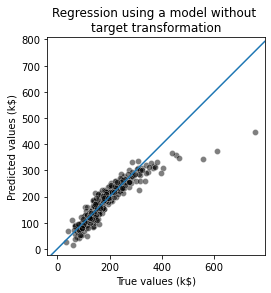

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

predicted_actual = {
    "True values (k$)": target_test,
    "Predicted values (k$)": target_predicted
}

predicted_actual = pd.DataFrame(predicted_actual)

sns.scatterplot(
    data=predicted_actual,
    x="True values (k$)",
    y="Predicted values (k$)",
    color="black",
    alpha=0.5
)

plt.axline((
    0, 0),
    slope=1,
    label="Perfect fit"
)

plt.axis('square')
_ = plt.title("Regression using a model without \ntarget transformation")

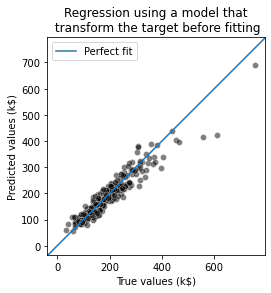

In [88]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor

"""
This method transforms the features to follow a uniform or a normal distribution. 
Therefore, for a given feature, this transformation tends to spread out the most frequent values. 
It also reduces the impact of (marginal) outliers: this is therefore a robust preprocessing scheme.
The transformation is applied on each feature independently. 
First an estimate of the cumulative distribution function of a feature is used to map the original values to a uniform distribution. 
The obtained values are then mapped to the desired output distribution using the associated quantile function. 
Features values of new/unseen data that fall below or above the fitted range will be mapped to the bounds of the output distribution. 
Note that this transform is non-linear. It may distort linear correlations between variables measured at the same scale but renders variables measured at different scales more directly comparable.
"""

transformer = QuantileTransformer(
    # this is the default value
    n_quantiles=1000,
    output_distribution="normal"
)

model_transformed_target = TransformedTargetRegressor(
    regressor=regressor,
    transformer=transformer
)

model_transformed_target.fit(
    data_train,
    target_train
)

target_predicted = model_transformed_target.predict(
    data_test
)


predicted_actual = {
    "True values (k$)": target_test,
    "Predicted values (k$)": target_predicted
}

predicted_actual = pd.DataFrame(predicted_actual)

sns.scatterplot(
    data=predicted_actual,
    x="True values (k$)",
    y="Predicted values (k$)",
    color="black",
    alpha=0.5
)

plt.axline(
    (0, 0),
    slope=1,
    label="Perfect fit"
)

plt.axis('square')

plt.legend()

_ = plt.title("Regression using a model that\n transform the target before "
              "fitting")

In [89]:
from sklearn.model_selection import cross_validate
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

model = LinearRegression()


scores = cross_val_score(
    model,
    data,
    target,
    cv=10,
    scoring="r2"
)

print(f"R2 score: {scores.mean():.3f} +/- {scores.std():.3f}")

scoring = ["r2", "neg_mean_absolute_error"]
cv_results = cross_validate(model, data, target, scoring=scoring)

scores = {
    "R2": cv_results["test_r2"],
    "MAE": -cv_results["test_neg_mean_absolute_error"]
}

scores = pd.DataFrame(scores)
scores

R2 score: 0.684 +/- 0.121


,R2,MAE
0,0.623595,0.234671
1,0.698961,0.214481
2,0.755933,0.180836
3,0.773021,0.169694
4,0.671920,0.196616


##### QUIZ 5

**1. What is the default score in scikit-learn when using a regressor?**

a) $R^2$

b) mean absolute error

c) median absolute error

<br>


**2. If we observe that the values returned by `cross_val_scores(model, X, y, scoring="r2")` increase after changing the model parameters, it means that the latest model:**

a) generalizes better

b) generalizes worse 

<br>

**3. If we observe that the values returned by `cross_val_scores(model, X, y, scoring="neg_mean_squared_error")` increase after changing the model parameters, it means that the latest model:**

a) generalizes better
 
b) generalizes worse 

<br>


**4. Values returned by `cross_val_scores(model, X, y, scoring="neg_mean_squared_error")` are:**

a) guaranteed to be positive or zero 

b) guaranteed to be negative or zero 

c) can be either positive or negative depending on the data


<br>